In [61]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Agents.Prio_n_step.Prio_DQN_Agent import Prio_DQN_Agent
from Agents.Pablo.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN
from Agents.Random.random_agent import RandomAgent
from Agents.utils.actions import MORE_ACTIONS
import Agents.utils.stats_functions as sf
import hockey.hockey_env as h_env

from Agents.Pablo.Agent import Dueling_DDQN_Agent
from Agents.Tapas_en_Mallorca.old.Agent import Combined_Agent
from Agents.Tapas_en_Mallorca.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN_better_mem

from importlib import reload

In [80]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 +  563 *i for i in range(500)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [83]:
reload(h_env)
agent_name = "random_training_4"
env_name = f"../last_chance/Possibilities/{agent_name}"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)
#env = gym.make("CartPole-v1", render_mode = "rgb_array")

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

#agent = Adaptative_Dueling_Double_DQN_better_mem(state_space, action_space, seed = seed, eps = 0.01,use_dueling = True, use_double = True, use_noisy = True, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5, env = env, use_more_actions = USE_MORE_ACTIONS)
agent = Adaptative_Dueling_Double_DQN(state_space, action_space, seed = seed,use_dueling = True, use_double = True, use_noisy = False, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], env = env, use_more_actions = USE_MORE_ACTIONS)
#agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5, env = env, use_more_actions = USE_MORE_ACTIONS)
agent.Q.load(env_name)

Dueling Network Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling Network Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from ../last_chance/Possibilities/random_training_4/weights/training_finished.pth


In [84]:
def test_agent(agent = agent, opponent = RandomAgent(seed), test_episodes  = len(SEEDS_TEST), max_steps = 30000, opponent_name = "random", agent_name = "", env_name = env_name):
   
    test_rewards = []
    test_name = f"{opponent_name}_vs_{agent_name}"
  
    games_won = 0
    games_lost = 0

    for episode in range(test_episodes):

        obs_agent1, _ = env.reset(seed = SEEDS_TEST[episode])
        #state = env.reset(seed = seed)
        env.action_space.seed(seed = SEEDS_TEST[episode])
        obs_agent1= obs_agent1[0] if isinstance(obs_agent1, tuple) else obs_agent1  # Handle Gymnasium compatibility

        obs_agent2 = env.obs_agent_two()
        obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

        total_reward = 0

        frames = []
        
        for t in range(max_steps):

            done = False

            """frame = env.render(mode = "rgb_array")
            if frame is not None:
                frames.append(frame)"""

            a1_cont = agent.get_step(obs_agent1)
            a2 = opponent.act(obs_agent2)

            full_action = np.hstack([a1_cont, a2])

            next_state, reward, done, truncated, info = env.step(full_action)
            
            total_reward += reward

            obs_agent1 = next_state
            obs_agent2 = env.obs_agent_two()

            if done or truncated: break

        result = info["winner"]

        if info["winner"] == 1:
            games_won += 1
        elif info["winner"] == -1:
            games_lost += 1

        test_rewards.append(total_reward)
        print(f"Test Episode {episode+1}, Total Reward: {total_reward} - Winner: {result}")
        
        if frames:
            os.makedirs(f"{env_name}/test_gifs/{test_name}", exist_ok=True)
            imageio.mimsave(f"{env_name}/test_gifs/{test_name}/test_episode_{episode+1}.gif", frames, fps=30)

    print(f"Winrate: {games_won}/{games_lost}: {games_won/(games_won+games_lost)} ({test_episodes - games_won - games_lost})")

    env.close()
    results_name = f"test_results_{test_name}"
    sf.save_test_results(env_name, test_rewards, name = results_name)

In [85]:
test_agent(agent_name = agent_name)

Test Episode 1, Total Reward: -13.233826804796966 - Winner: -1
Test Episode 2, Total Reward: 9.390582839329428 - Winner: 1
Test Episode 3, Total Reward: -11.011274267034 - Winner: -1
Test Episode 4, Total Reward: -30.22245348119227 - Winner: 0
Test Episode 5, Total Reward: 0.0 - Winner: 0
Test Episode 6, Total Reward: 7.760251371066458 - Winner: 1
Test Episode 7, Total Reward: 0.0 - Winner: 0
Test Episode 8, Total Reward: -28.67303416605635 - Winner: 0
Test Episode 9, Total Reward: 7.146923658388222 - Winner: 1
Test Episode 10, Total Reward: -40.229018177375664 - Winner: 0
Test Episode 11, Total Reward: 0.0 - Winner: 0
Test Episode 12, Total Reward: -12.185674128697938 - Winner: 0
Test Episode 13, Total Reward: 0.0 - Winner: 0
Test Episode 14, Total Reward: 9.188610823745936 - Winner: 1
Test Episode 15, Total Reward: 0.0 - Winner: 0
Test Episode 16, Total Reward: -37.569433086517996 - Winner: 0
Test Episode 17, Total Reward: 6.2755935562906 - Winner: 1


KeyboardInterrupt: 

Test Episode 1, Total Reward: 9.828271013053456 - Winner: 1
Test Episode 2, Total Reward: 9.572284748076179 - Winner: 1
Test Episode 3, Total Reward: 9.934146293576354 - Winner: 1
Test Episode 4, Total Reward: 4.792384614005117 - Winner: 1
Test Episode 5, Total Reward: 9.8436063986824 - Winner: 1
Test Episode 6, Total Reward: 8.013347906844812 - Winner: 1
Test Episode 7, Total Reward: 9.978886667246845 - Winner: 1
Test Episode 8, Total Reward: 7.276223437089392 - Winner: 1
Test Episode 9, Total Reward: 9.325170722148254 - Winner: 1
Test Episode 10, Total Reward: -15.062668834300315 - Winner: -1
Test Episode 11, Total Reward: -10.58223931333769 - Winner: -1
Test Episode 12, Total Reward: 0.01129826898057118 - Winner: 1
Test Episode 13, Total Reward: 9.748953028204864 - Winner: 1
Test Episode 14, Total Reward: 7.3882912510417995 - Winner: 1
Test Episode 15, Total Reward: 9.750723641624141 - Winner: 1
Test Episode 16, Total Reward: 1.6147257827713677 - Winner: 1
Test Episode 17, Total Rew

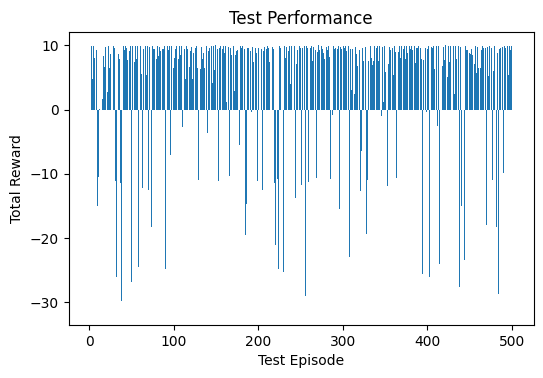

In [72]:
test_agent(opponent = h_env.BasicOpponent(weak=True), opponent_name = "weak", agent_name = "agent_name")

Test Episode 1, Total Reward: -6.247167846116365 - Winner: 0
Test Episode 2, Total Reward: -10.634382178857663 - Winner: 0
Test Episode 3, Total Reward: -13.55610211939017 - Winner: -1
Test Episode 4, Total Reward: 1.1711046010741715 - Winner: 1
Test Episode 5, Total Reward: -5.155624131570616 - Winner: 0
Test Episode 6, Total Reward: 8.877510375523888 - Winner: 1
Test Episode 7, Total Reward: 8.075158569178935 - Winner: 1
Test Episode 8, Total Reward: 8.218880439696647 - Winner: 1
Test Episode 9, Total Reward: -13.12965266905083 - Winner: -1
Test Episode 10, Total Reward: 2.909406493990071 - Winner: 1
Test Episode 11, Total Reward: 6.7277633379305195 - Winner: 1
Test Episode 12, Total Reward: 0.6231059907085346 - Winner: 1
Test Episode 13, Total Reward: 7.646274816975001 - Winner: 1
Test Episode 14, Total Reward: 9.259377430703445 - Winner: 1
Test Episode 15, Total Reward: -4.606376056884559 - Winner: 0
Test Episode 16, Total Reward: 7.36910875605353 - Winner: 1
Test Episode 17, Total

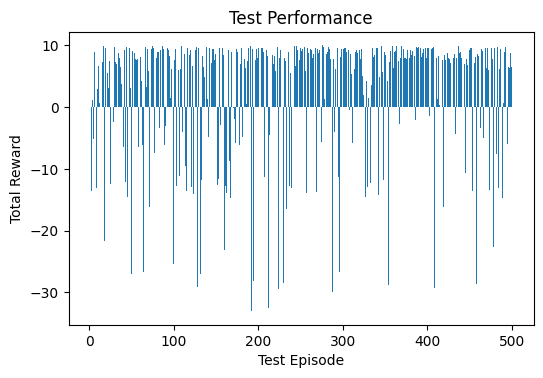

In [73]:
test_agent(opponent = h_env.BasicOpponent(weak=False), opponent_name = "non_weak", agent_name = agent_name)